# Optimizing a neural network

In the previous notebook, we saw how to use linear transformations to fit, or approximate, a set of parameters to to capture the distributions of two types of data. The first distribution was produced by a simple mathematical function: $f(x) = x^2$, which maps a single input value to a single output value. The second distribution was in the form of the boston housing data set, where a 12 dimensional feature vector was mapped to a single contiuous value representing a house price. 

In order to optimize these function approximations, we employed a technique called stochastic, or sequential, mini-batch gradient descent. Gradient descent is a technique used to minimize the error of many machine learning algorithms when fitting parameters to some target distribution. We glossed over the details of this algorithm in the previous notebook, but we'll take a closer look at how this work here. 


#### Function optimization
Optimization techniques are a core aspect of training machine learning models, and it is useful to be aware of some of the concepts associated with optimization theory since the approach chosen can dramatically affect the final model result as well as the amount of time it takes to get there. 

Function optimization is an entire field of study that can generally be divided in to two categories: convex optimization and non-convex optimization. We will explore some of the basics of convex function optimiziation, which tends to be easier to think about (in my opinion), in order to better understand the actual non-convex optimization hurdles we face when working with neural networks.

#### What we will cover
In this notebook we'll cover:
 - Terminology associated with function optimization
 - Minimization/maximization of non-parameterized functions
     - learning input/output values
 - Optimizing free parameters of a parameterized function to model a target distribution
     - learning parameters to match output values to target output values
 - How a neural network is optimized
  
 This notebook follow information presented in:
 http://www.deeplearningbook.org/

#### Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def formatter(ax=None, title=''):
    "Helper to set a grid and 0 axis lines"
    if not ax:
        plt.grid(True, alpha=0.4); plt.axvline(0, alpha=0.6); plt.axhline(0, alpha=0.6); plt.title(title)
        return plt
    else:
        ax.grid(True, alpha=0.4); ax.axvline(0, alpha=0.6); ax.axhline(0, alpha=0.6); ax.set_title(title)
        return ax

# Introduction to the basics of function optimization

Most readers coming across this notebook are probably quite familiar with functions and how to optimize them. The ideas we're talking about here are basically the same thing, only here we're concerned with functions that explicitely execute mathematical operations and we are optimizing the values that are returned - as apposed to optimizing run time or algorithm complexity.

In this framing, mathematical function optimization can generally be divided in another two ways. On the one hand, we might have an explicit function for which we would like to find the inputs that returns the maximum or minimum outputs. We can think of this as **function minimization/maximization**. On the other hand, we might have a parameterized function for which we would like to find the set of parameters that return the smallest error between an output and some target value. We can think of this as **parameter optimization/error minimization**.

## Non-Parameterized (explicit) functions

#### Lets consider a linear function

When we explicitely define an unparameterized function, we may encounter situations where we would like to minimize or maximize the function. In otherwords, we would like to find the input that produces the maximum output. For some functions, this is trivial. For example, a linear function that increases as the input increases is maximized by selecting the input that is equivalent to the upper bound of the function's domain. 

$$ f(x) = mx + b$$
`where m and b are constant`

Linear functions are a member of a class of functions referred to as **monotonic functions**, since they either always increase to the right (*monotonically increasing*) or decrease to the right (*monotonically decreasing*). The main idea is that a monotonic function never decreases once it starts increasing for a given direction.

To minimize or maximize a monotonic function that is defined for all real values ($-inf$ to $inf$), we can bound the function, making input values outside the bounds undefined.

In [3]:
def linear(x, m):
    assert max(x) <=  10, 'upper bound crossed'
    assert min(x) >= -10, 'lower bound crossed'
    return x * m

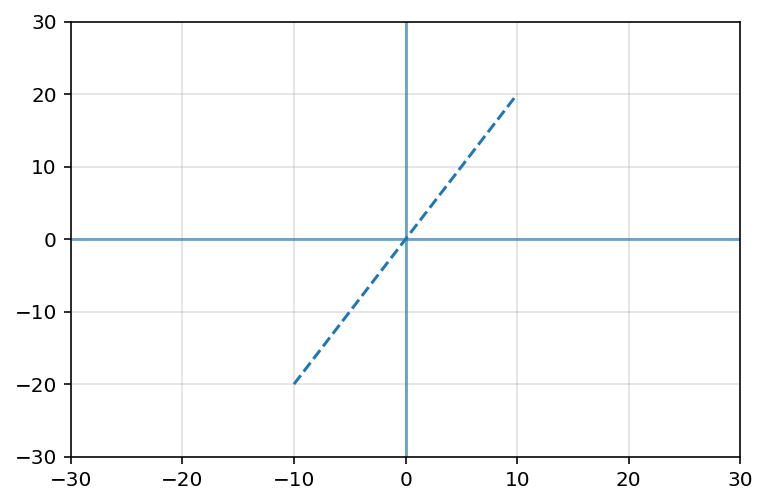

In [4]:
x = np.array([-10, 10])
y = linear(x, 2)
plt.plot(x, y, linestyle='--')
formatter()
plt.xlim((-30, 30));plt.ylim((-30, 30));

We have bounded the min and max output of the __linear__ function above at -20 and 20, respectively. If we cross the upper bound...

In [5]:
x = np.array([-10, 11])
linear(x, m=2)

AssertionError: upper bound crossed

... we get an assertion error. If we don't bound this function, it is intuitively obvious from looking at the plot that the function will increase towards infinity when we increase the input and decrease towards negative infinity as we decrease the input.

### Now consider a non-linear function

Linear functions are always monotonic when slope is greater than zero (when the function doesn't define a flat horizontal line), but non-linear functions may not be. Take for example the simple function $f(x) = x^2$

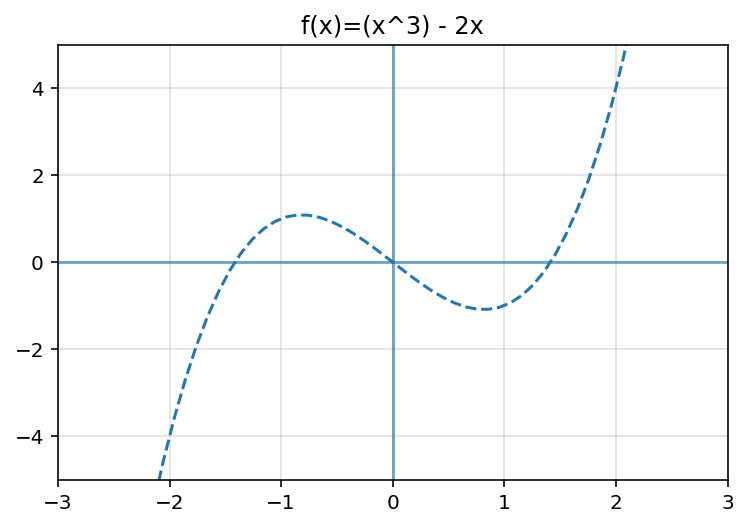

In [6]:
def non_linear(x):
    return (x**3) - 2.*x

x = np.linspace(-10, 10, 200)
y = non_linear(x)
plt.plot(x, y, linestyle='--')
formatter(title='f(x)=(x^3) - 2x')
plt.xlim((-3, 3));plt.ylim((-5, 5));

This is clearly not a monotonic function and we can make a choice - do we want to find a maximum or a minimum value? Furthermore, the line doesn't not linearly increase (i.e. the y-value output by the function does not increase proportionally to increases in the input x).

If we simplify this and only consider points the right of $x = 0$, then we can see that the function is actually monotonic for this set of numbers. In this case, we can maximize the function by choosing infinity or minimize by choose zero. For that matter, this function is trivial in that it is quite simple to tell that the smallest output value is always when x = 0. 

So lets say then that we want to develop an approach for determining when the output value is at its smallest. There are two ways to do this: **numerically** and **analytically**. 'Numerically' basically means, '*try out a whole bunch of numbers and see which one gives you the closes answer*', which may yield a close approximation at best. Analytical approaches yield formula that yield exact solutions. There may or may not be analytical solutions to a given optimization problem, and it may be impractible or unfeasible to try and work out an analytical solution.

So how can we numerically determine the maximum or minimum of a non-linear function?

### Calculus - the analytical tool for minimization and maximization

For many, 'calculus' is a loaded word that conjures fear from the deepest, darkest places of the mind. It is typically considered the point at which advanced math begins and the desire to continue studying ends. Its the point at which the world of math seems to spread infinitely to the left and right with no telling how far forward it goes.

In order to understand how neural network optimization actually works, we don't need to understand the vastness of math beyond calculus. We only need to focus on a few key areas that are used in practice. But there are a few words you do need to be(come) comfortable with. These words include:

 - derivative (first order, second order)
 - partial derivative (Jacobian, Hessian)
 - gradient
 - local minimum/minima
 - local maximum/maxima
 - critical point
 
 These words will pop up throughout the rest of this notebook.

### The derivative

An important concept from calculus is the derivative. The derivative of a function gives us information about the rate at which the output of that function changes as its inputs change. Finding the derivative of a function can be tricky depending on the function, so in this notebook we'll only talk about functions whose derivatives are relatively simple to find.

Lets rewind for a moment to our linear function so we can do a quick comparison. This function had a constant slope. So for the linear function...

$$f(x) = 2x$$

...it should be clear if you pass a value $x$ to $f(x)$, then the output of $f(x)$ will always return a value that $ 2 * x$. In other words, there is a _constant tranformation_ to the value of $x$ applied to the input $x$ which is indicted by the _constant_ $2$.

For a non-linear function, this is not the case. For example, the function...

$$f(x) = x^2$$

...does not scale constantly as the linear function does. Instead, it scales with the square of the input. Lets take a peek at what this looks like.

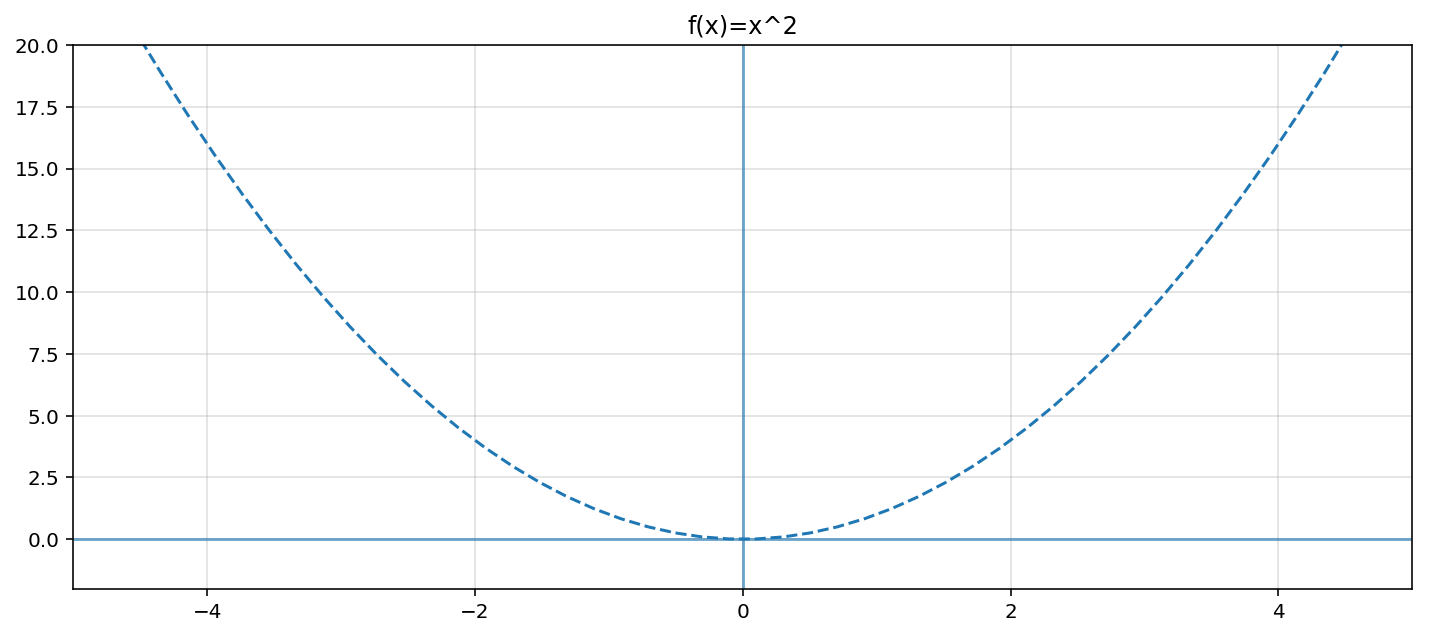

In [7]:
def non_linear(x):
    return x ** 2

x = np.linspace(-10, 10, 100)
y = non_linear(x)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, linestyle='--')
formatter(title='f(x)=x^2')
ax.set_xlim((-5, 5));ax.set_ylim((-2, 20));

If you look closely, you'll see that when $x$ is near zero, the slope of the the curve at that point $x$ is pretty shallow (doesn't increase quickly), but when $x$ is far from zero, the slope of the curve is pretty steep. The slope can be visualized by imagining a line that is tangent to the function at a given point.

What does this even mean!? Enough words! Lets take a look!

In [8]:
def slope_at_point(x):  # Don't worry just yet about this function
    return 2*x

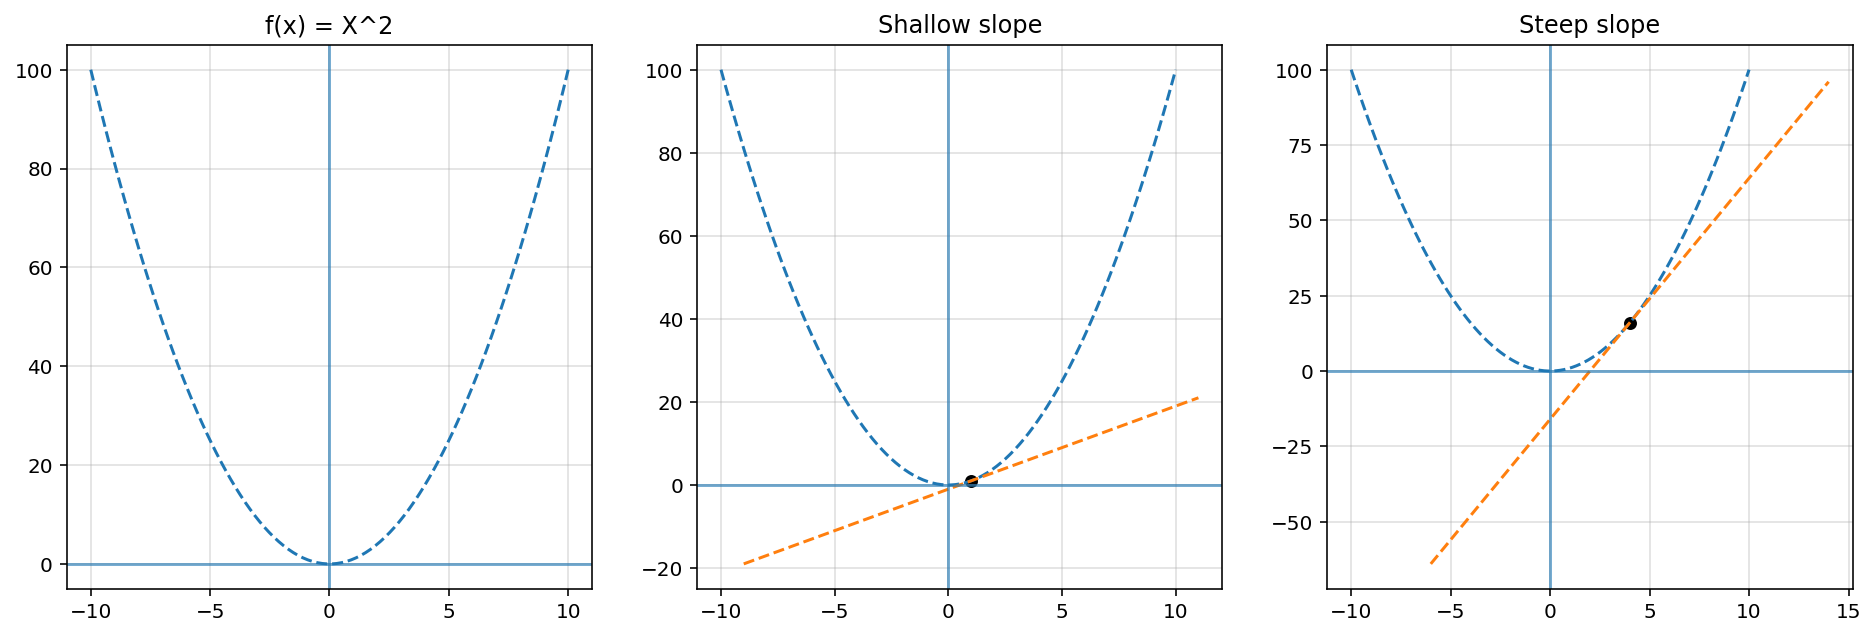

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, **{'figsize':(16, 5)})
x = np.linspace(-10, 10, 100)
y_nl = non_linear(x)

# Plot 1
ax = axes[0]
ax.plot(x, y_nl, linestyle='--')
formatter(ax=ax, title='f(x) = X^2')

#---------------------------------------------------------
# Plot 2
ax = axes[1]
m = slope_at_point(1)
y = linear(x, m=m)
y_shift = non_linear(1)

ax.plot(x, y_nl, linestyle='--') # original non-linear function
ax.plot(x+1, y+y_shift, linestyle='--')  # Tangent line, i.e. slope at point
ax.scatter(1, y_shift, s=30, c='black')   # point
formatter(ax=ax, title='Shallow slope')

#---------------------------------------------------------
# Plot 3
ax = axes[2]
m = slope_at_point(4)
y = linear(x, m=m)
y_shift = non_linear(4)

ax.plot(x, y_nl, linestyle='--') # original non-linear function
ax.plot(x+4, y+y_shift, linestyle='--')  # Tangent line, i.e. slope at point
ax.scatter(4, y_shift, s=30, c='black')   # point
formatter(ax=ax, title='Steep slope');

So for all the $x$ values between 0 and 2, the slope of the orange line is more shallow that the slope of the orange line between values 2 and 4.

##### The function that we use to draw this line is the derivative.

The derivative is incredibly informative. In the example above, it tells us which direction we need to shift the input values in order to find a smaller output value for the function. In the same way, it gives us information about the maximum of the function.

Consider the orange line in the center image (shallow slope). Its sloping up and to the right. So if we move our input to the right, the output will increase because the rate of change is increasing towards the right. Similarly, the organge line is decreasing towards the left, so the rate of change decreases towards the left and as such the output values will decrease.

This is remarkable! If that organge line ever has a slope of zero, we know that at that point, there is no rate of change at that point, which means the input has hit a **critical point** - a point where the function is neither increasing nor decreasing with respect to the input.

For a **convex function**, a **critical point** defines the **global minimum** of the function. $f(x) = x$ is a convex function, and a the slope of the derivative at the critical point is zero when the input is equal to zero. 

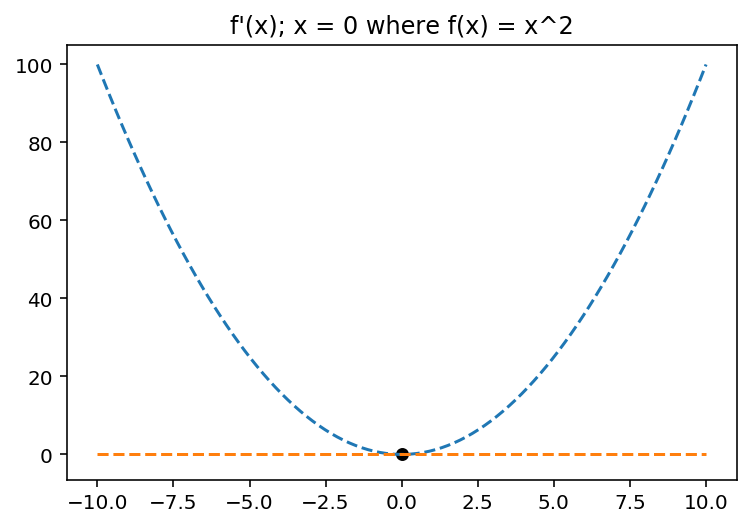

In [10]:
# Plot the derivative when the derivative equals zero
x = np.linspace(-10, 10, 100)
m = slope_at_point(0)
y = linear(x, m=m)
y_shift = non_linear(0)

plt.plot(x, y_nl, linestyle='--') # original non-linear function
plt.plot(x, y, linestyle='--')  # Tangent line, i.e. slope at point
plt.scatter(0, y_shift, s=30, c='black'); plt.title("f'(x); x = 0 where f(x) = x^2");

You can see now that when the derivative function returns zero, we've hit a point at which the output of the function is minimized since the output will increase if we go either left or right.

For functions where there is only a single critical point, that point may be considered the **global minimum**. And for these fucntions we use the term *convex function*. $f(x) = x^2$ is one such function. There is a subfield of optimization called convex optimization that is interested is finding efficient numerical and analytical solutions for the optima of convex functions. 

https://en.wikipedia.org/wiki/Convex_optimization  
https://en.wikipedia.org/wiki/Convex_function

But not all functions are convex. For example, when we begin making a function more complex by adding terms to a linear function (making it a polynomial) that are of a higher order (e.g. x^2, x^3, ...), we begin to encounter functions that may have multiple **local minima**, of which one or more may be the **global minima**.

Take for example the function:

$$f(x) = \frac{1}{4}x^4 + \frac{1}{3}x^3 - \frac{1}{2}x^2$$

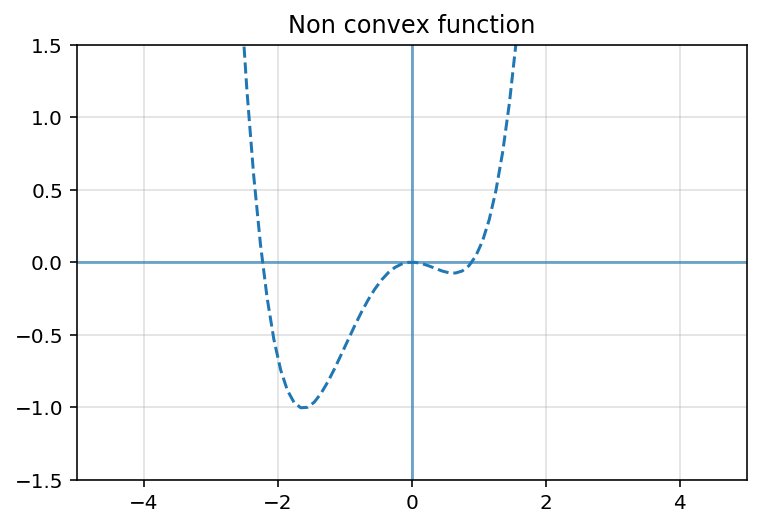

In [11]:
def higher_degree_polynomial(x):  
    return ((1/4)*x**4) + ((1/3)*x**3) -((1/2)*x**2)

x = np.linspace(-10, 10, 200)
y = higher_degree_polynomial(x)

plt.plot(x, y, linestyle='--')
formatter(title='Non convex function');
plt.xlim((-5, 5)); plt.ylim((-1.5, 1.5));

It is probably clear from the graph above that there are two **local minima** for the function, only one of which is the global minimum. This is therefore a non-convex function for which there can be no convex-optimization technique that finds the global minimum. (However, if the function should be bounded such that, say, $x >= 0$, then in some respects the function may be considered convex). 

So to find the points at which the function above is locally minimized, we find the **derivative function** $f'(x)$ and find the points x at which the derivative function is equal to zero i.e. $f'(x) = 0$

## How do you find the derivative?

This is probably a good time to talk briefly about how to find the derivative of a function. In school (as I recall anyways), there were two ways to find the derivative of a function. One way was to take the limit of the function between two points as the distance between those two points went to zero. The other way was use a trick involving bring down the exponent. I think the trick is the method people typically remember and use whenever possible, so we'll just recap that here.

Take the function:
$$f(x) = 4x^2 + 5^1$$

To find the derivative $f'(x)$, we perform the following operations:

$$f(x) = 4x^2 + 5$$
$$= 4x^2 + 5x^0 $$


$$f'(x) = (2)*4x^{2-1} + (0)*5^{0-1}$$

$$ = 8x$$

So we multiply the term by the exponent value, then subtract 1 from the exponent of the term. Constants are eliminated.

So for the function plotted above, we would do:

$$f(x) = \frac{1}{4}x^4 + \frac{1}{3}x^3 - \frac{1}{2}x^2$$

Therefore...

$$f'(x) = x^3 + x^2 - x$$

If you're interested, a quick youtube search brought up the harder way to find the derivative at a point:  
https://www.youtube.com/watch?v=PMKr97AstNU

So to find the points in the plot that exist as minima and maxima, we simply find the solutions for which the output of this function is equal to zero. There are various approaches to do this. In school, we learned how to do this **analytically** by factorizing the function such that we were left with factors with obvious zero solutions.

For example, to find the zeros of the function:
$$f(x) = 2x^2 + 5x - 3$$

We factorize the function to get:

$$f(x) = (2x + 1)(x + 3)$$

Setting this to zero means that any time either group within the parenthesis is equal to zero, the function evaluates to zero. So the zeros are:

$$2x+1 = 0$$
$$x=-\frac{1}{2}$$

and

$$x+3 = 0$$
$$x=-3$$

When the function doesn't have integer solutions, there are other ways to find the root of the polynomials such as employing the rational zeros theorem. 

But this is TEDIOUS! Especially when we have to do it a million times! Plus, I don't remember off the top of my head how this all works. 

**This is one reason (not my memory) that the derivative is so interesting. The derivative tells us not only the slope at a given input, but also the direction in which we can alter the input $x$ so as to increase or decrease the output!**

If we take the previous example of the convex function $f(x) = x^2$, we can see this in practice.

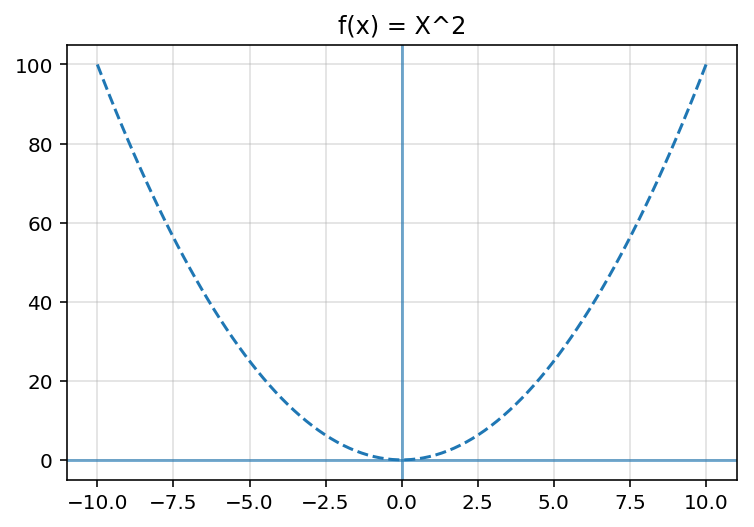

In [12]:
x = np.linspace(-10, 10, 100)
y_nl = non_linear(x)

plt.plot(x, y_nl, linestyle='--')
formatter(ax=None, title='f(x) = X^2');

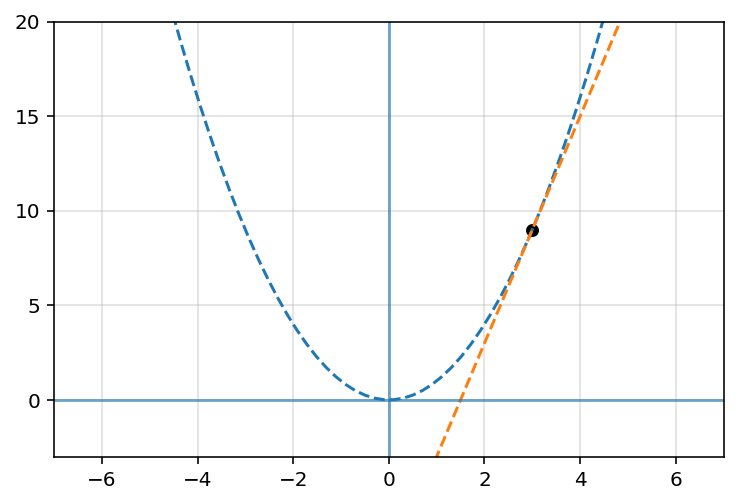

In [13]:
x = np.linspace(-10, 10, 100)

point = 3
m = slope_at_point(point)
y = linear(x, m=m)
y_shift = non_linear(point)

plt.plot(x, y_nl, linestyle='--') # original non-linear function
plt.plot(x+point, y+y_shift, linestyle='--')  # Tangent line, i.e. slope at point
plt.scatter(point, y_shift, s=30, c='black')   # point
formatter(title='');
plt.xlim((-7, 7)); plt.ylim((-3, 20));

The `slope_at_point` function is defined as $f'(x) = 2x$ which is the derivative function of $f(x) = x^2$. At the input point 3, the slope is _positive_ 6.

In [14]:
slope_at_point(3)

6

So this tells us that the curve is increasing from left to right along the x-axis. If the slope at the point were negative, we would know that the function outputs were decreasing as we moved from left to right.

In [15]:
slope_at_point(-3)

-6

We can visualize this change in slope as we move across the x axis.

In [16]:
points = np.asarray(range(-6, 6))
len(points)

12

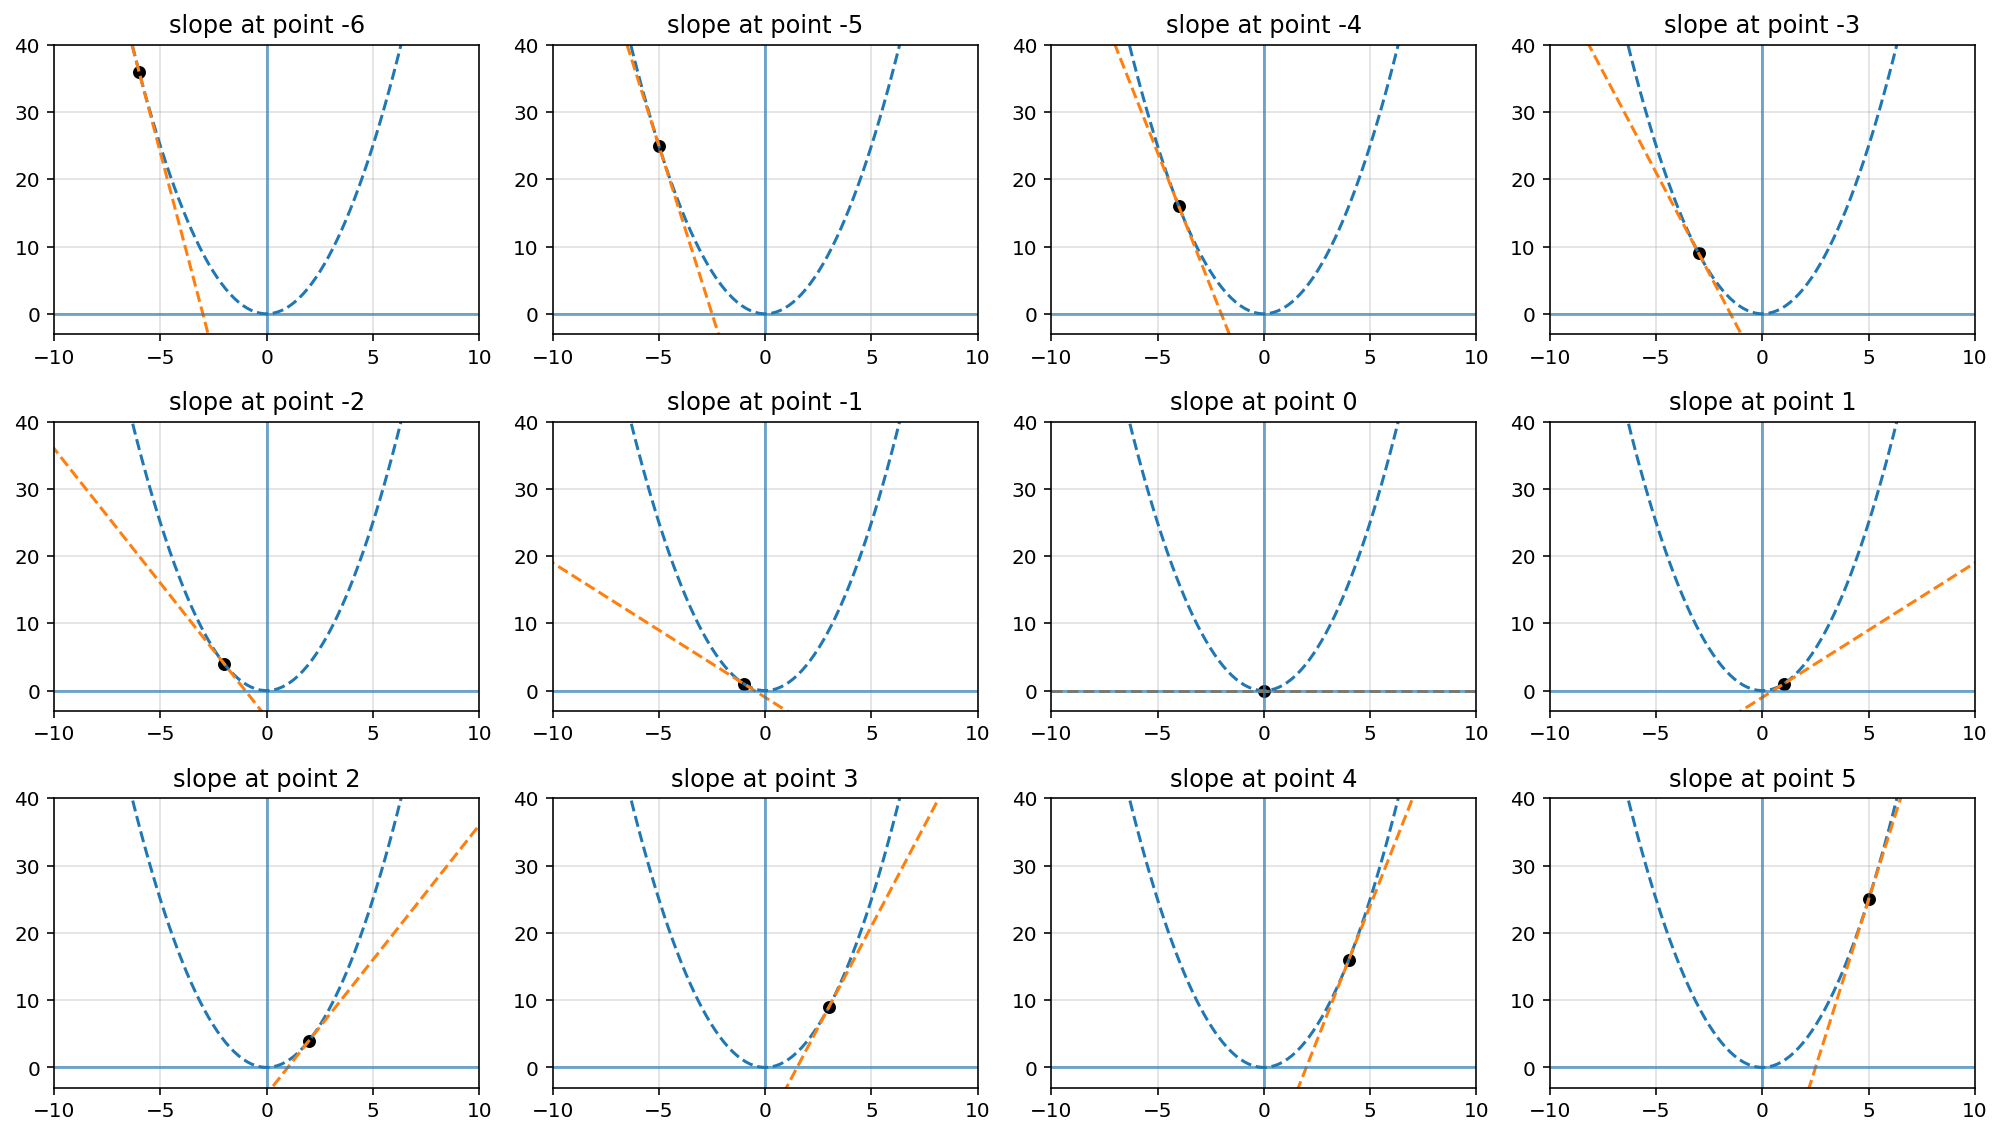

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, **{'figsize':(14, 8)})
points = np.asarray(range(-6, 6))
x = np.linspace(-10, 10, 100)
y_nl = non_linear(x)

for point, ax in zip(points, axes.flatten()):
    
    m = slope_at_point(point)
    y = linear(x, m=m)
    y_shift = non_linear(point)

    ax.plot(x, y_nl, linestyle='--') # original non-linear function
    ax.plot(x+point, y+y_shift, linestyle='--')  # Tangent line, i.e. slope at point
    ax.scatter(point, y_shift, s=30, c='black')   # point
    formatter(ax=ax, title='slope at point {}'.format(point));
    ax.set_xlim((-10, 10)); ax.set_ylim((-3, 40));
    plt.tight_layout()

# Read from top left to bottom right

### Derivative descent
From here, we can develop an understanding of the algorithms that have been discovered which allow us to automatically optimize functions. Let's start by trying to write a simple one ourselves!

Starting Point:  5.0
Iterations until optimized: 57
Final x: -1.4965776766268396e-05
Slope at final : -8.979466059761037e-05


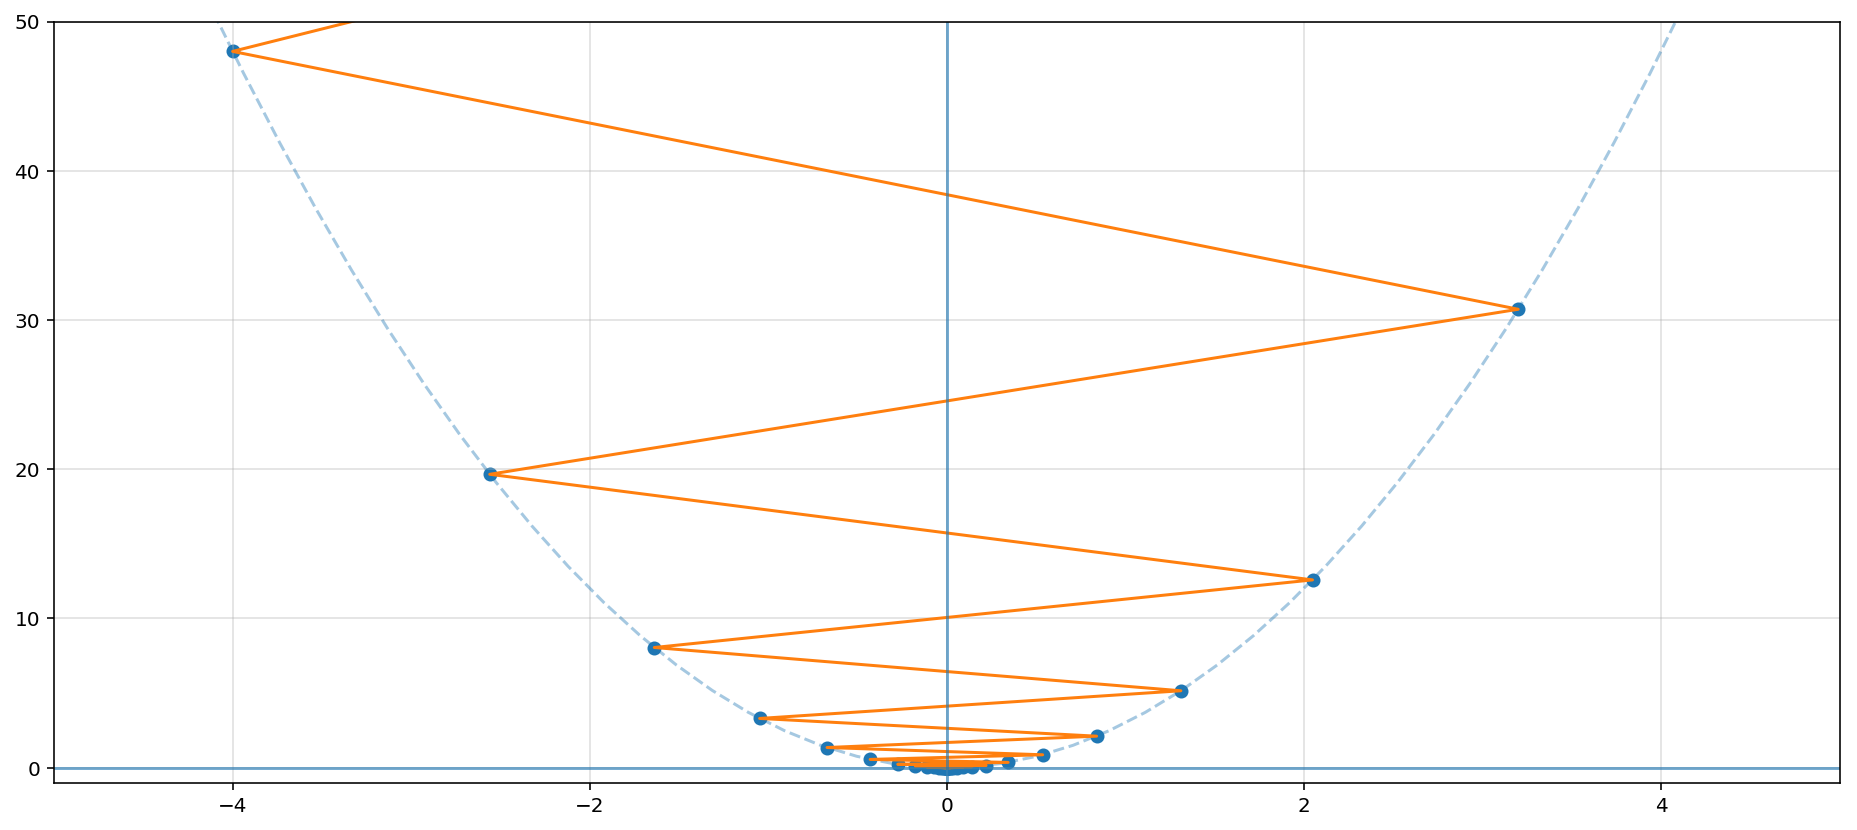

In [18]:
def function_to_optimize(x):
    return 3*(x**2)
def derivative_of_function(x):
    return 6*x
scaling_coef = 0.3
x_point = -5.


# # # Try this function out too!
# def function_to_optimize(x):
#     return ((1/8)*x**4) + ((1/3)*x**3) - ((1/2)*x**2) - 2
# def derivative_of_function(x):
#     return ((1/2)*(x**3)) + (x**2) - x

scaling_coef = .3
x_point = 5. #np.random.randint(-10, 10)


minimum_acceptable_threshold = 0.0001
print('Starting Point: ', x_point)
max_iterations = 3000
xs = list()

iterations = 0
slope = derivative_of_function(x_point)

xs.append(x_point)
while abs(slope) > minimum_acceptable_threshold:

    x_point -= derivative_of_function(x_point) * scaling_coef
    xs.append(x_point)

    iterations += 1
    if iterations > max_iterations:
        break
        
    slope = derivative_of_function(x_point)

# Plot out optimization progress
fig, ax = plt.subplots(figsize=(16, 7))
xline = np.linspace(-10, 10, 100)
yline = function_to_optimize(xline)
ax.plot(xline, yline, linestyle='--', alpha=0.4)
ax.plot(xs, [function_to_optimize(x) for x in xs]);
ax.scatter(xs, [function_to_optimize(x) for x in xs]);

ax.set_ylim((-1, 50));ax.set_xlim((-5, 5))
# ax.set_ylim((-10, 10));ax.set_xlim((-6, 6))

formatter()

print("Iterations until optimized: {}".format(iterations))
print("Final x: {}".format(x_point))
print("Slope at final : {}".format(derivative_of_function(x_point)))

It took some tweaking to get this algorithm to perform, and we can glean quite a bit about how we can use the derivative to find the minimum of these functions. 

We don't normally write these algorithms out ourselves though. We could employ some tools available in scipy.

In [19]:
from scipy.optimize import fmin, minimize, OptimizeResult

In [20]:
# For non-derivative methods
fmin(function_to_optimize, x0=5)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 40


array([0.])

In [21]:
# For derivative based methods
minimize(function_to_optimize, x0=-15)

      fun: 6.847287396274741e-12
 hess_inv: array([[0.16666665]])
      jac: array([-9.01992275e-06])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([-1.51077104e-06])

In [22]:
print(OptimizeResult.__doc__)

 Represents the optimization result.

    Attributes
    ----------
    x : ndarray
        The solution of the optimization.
    success : bool
        Whether or not the optimizer exited successfully.
    status : int
        Termination status of the optimizer. Its value depends on the
        underlying solver. Refer to `message` for details.
    message : str
        Description of the cause of the termination.
    fun, jac, hess: ndarray
        Values of objective function, its Jacobian and its Hessian (if
        available). The Hessians may be approximations, see the documentation
        of the function in question.
    hess_inv : object
        Inverse of the objective function's Hessian; may be an approximation.
        Not available for all solvers. The type of this attribute may be
        either np.ndarray or scipy.sparse.linalg.LinearOperator.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
   

## The gradient

For functions that have a single input (a scalar) that maps to a single output, the derivative gives us a single value that corresponds to the slope of the function at the given point. When we deal with functions that take multiple inputs (i.e. a multidimensional array of inputs), we encounter the notion of a **partial derivative**. The partial derivative is simply the derivative of the part of the function that corresponds to one of the inputs. So for example, if we have a vector...

$$[x=3, y=4, z=5]$$

And we pass this to a function...

$$f(a, b, c) = 2a + 10b^2 - c^4$$

Then the partial derivatives of this **multivariable function** correspond to the inputs x, y and z. So if we wish to optimize this function using derivatives, we can take the partial derivatives by assessing the derivative of each variable, one at a time. 

$$\frac{da}{dy} = 2 $$
$$\frac{db}{dy} = 20b $$
$$\frac{dc}{dy} = -4c^3 $$

The vector of partial derivatives that we produce by doing is referred to as the **gradient** of the function. We can optimize multivariable functions by computing the gradient similar to how we optimized the function using the derivative in the previous example.



$$\bigtriangledown f(a, b, c) = [\frac{{\partial}y}{{\partial}a}, \frac{{\partial}y}{{\partial}b}, \frac{{\partial}y}{{\partial}c}]$$

where the symbol $\partial$ indicates the partial derivative. Note - each element in the list above is the result of passing the original input value for that variable through the partial derivative function for the corresponding portion of the function that uses that variable.

In [23]:
def multivariable(x):
    " where x is an array equivelant to [a, b, c]"
    return ((1/4)*x[0]**4) + ((1/3)*x[1]**3) -((1/2)*x[2]**2)

In [24]:
res = minimize(multivariable, x0=np.random.randint(0, 5, size=3), method=None)
res

      fun: -136227819409.89465
 hess_inv: array([[ 0.06603609,  0.22666565, -0.09812079],
       [ 0.22666565,  0.77792602, -0.33674114],
       [-0.09812079, -0.33674114,  1.198495  ]])
      jac: array([-2.18339328e+08,  6.36067840e+07, -2.04800000e+03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 167
      nit: 2
     njev: 31
   status: 2
  success: False
        x: array([ -602.15821911, -7975.35405306,  2161.29167761])

In [25]:
multivariable(res.x)

-136227819409.89465

#### Manually minimizing a multivariable parameterized linear function by gradient descent

Let's say we have a multivariable linear function...

$$f(x) = \frac{1}{2}(Ax − b)^2$$

...where $x$ is multivariable vector of inputs, $A$ is a matrix of linear functions, and b is a bias vector. We can think of this matrix as a multivariable function since there are multiple inputs mapping to specific bits of the function, which are then combined together in a predefined way. We use the concept of the gradient to minimize this function by doing, in essence what we did above with our toy minimization algorithm.

Let's define these variables so we have a concrete understanding of what we mean by the math notation:

In [26]:
x = np.random.randint(0, 10, size=(5, 1))  # We chose to make this function take 5 variables as input
A = np.random.randint(0, 25, size=(4, 5))  # We define the matrix A to be compatible with x
b = np.random.randint(0, 10, size=(4, 1))  # We define b to be compatible with x

Our input vector could be any shape (depending on the data we are modeling on), but we choose 5 inputs here arbitrarily. The shape of matrix $A$ is chosen to be compatible with the input, but the coefficients of $A$ (i.e. the values of $A$) are chosen at random. If this were a real world example, we might choose more meaningful values for $A$. In this example, we aren't trying to change the values of $A$, we're trying to change the values of $x$.

In [27]:
A

array([[18, 11, 24,  0, 17],
       [20, 18, 17,  5, 17],
       [20, 11, 24, 17, 10],
       [ 0, 24, 23,  6,  2]])

In [28]:
x

array([[9],
       [0],
       [2],
       [6],
       [7]])

In [29]:
b

array([[1],
       [1],
       [4],
       [4]])

Let's compute the output of our function given our randomly chosen starting input values.

In [30]:
0.5 * (A.dot(x)) - b

array([[163.5],
       [180.5],
       [196. ],
       [ 44. ]])

Cool, it works!

Now, to find the vector $x$ that minimizes the ouput of this function, we compute the gradient, and then step the input vector in the appropriate direction. So the first thing to do here is to compute the gradient by finding the function that outputs the partial derivatives of the original function.

Deriving gradients can seem like a bit of a leap because at this point we probably aren't too comfortable with manipulating the notation. Thats okay! We'll show how this is derived just so we aren't causing any unexplainable leaps in information. But don't worry too much about this - its merely here to show that it can be done.

To compute the gradient, we can first expand the function so that we can break it in to individual terms. Remember, the gradient is just the partial derivatives with respect to the input vector $x$, and when we find partial derivatives, we hold all other terms constant. And recall that the derivatives of constants evaluate to zero since they don't change over time/inputs. Also recall that $b$ is a vector of constants.

$$f(x) = \frac{1}{2}||Ax − b||^2$$

To compute the gradient, we can use the chain rule to quickly derive the derivative of this function, which is summarized as: derivative of outside multiplied by derivative of inside.

$$\bigtriangledown f(x)= \frac{dy}{du}\frac{du}{dx}$$

$$ =  \frac{2}{2}||Ax - b||^1 *  \frac{du}{dx}$$

$$ = (Ax - b) * A $$ 

The reason this works out is because the matrix A is a matrix of coefficients that correspond to a linear function. The derivative of a linear function is the value of the coefficients.

https://math.stackexchange.com/questions/1990066/how-does-ax-btax-b-reduce-to-xtatax-%E2%88%92-2btax-btb/1990086

With the form of the gradient identified, we can create a super simple algorithm to minimize the input vector $x$!

In [31]:
eps = 0.0000001
for i in range(2000000):
    grad = np.matmul(A.T, np.matmul(A, x))
    x = x - grad * eps
print(x)

[[-1.18120664]
 [-0.25944728]
 [-0.05685887]
 [ 0.75613612]
 [ 1.49883431]]


For those interested in what real world minimization/maximization problems might look like:
https://www.math.drexel.edu/~jwd25/CALC1_SPRING_06/lectures/lecture9.html

# Parameterized Functions

So far, we've used explicitely defined functions to get a handle on derivatives, partial derivatives, and the concept of the gradient. We've used these ideas to find minima of explicetely defined functions where the only values that change are the input values. We can also use these ideas to optimize parameterized functions. 

#### What is a parameterized function?
A parameterized function is one that takes variable inputs, but also has variables defined as part of the function. We've already seen a parameterized function - the neural network we created in the previous notebook. But we can recap using a much more simple parameterized function.

$$f(x) = mx + b$$
`where m and b are variable parameters`

We've actually seen this function a couple times! But in the context of a non-parameterized function! If we allow the `m` and `b` to change, we can consider these functions parameterized - and we can change these paramters to produce some desired pattern in the output given some set of inputs.

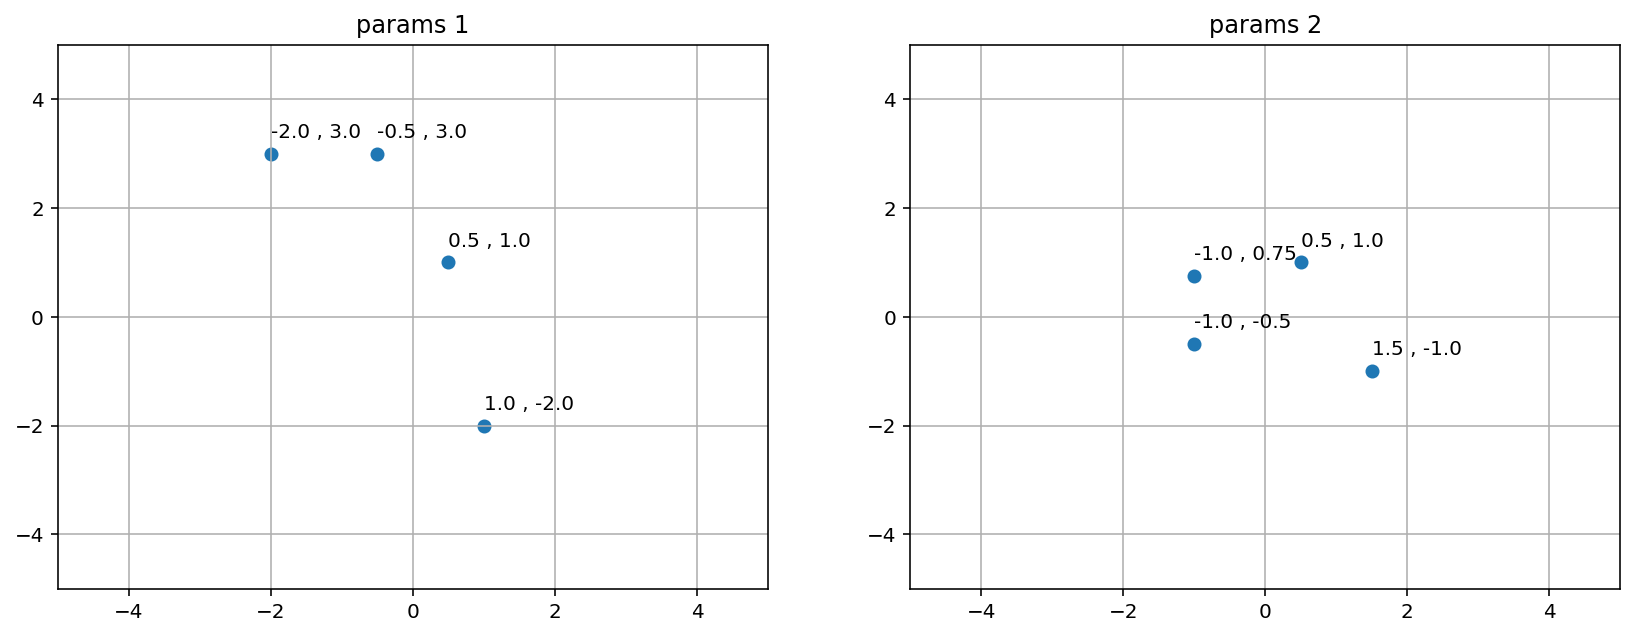

In [32]:
def parameterized(x, params):
    ' 4d vector to 2d space '
    return [sum([x*y for x, y in zip(x, param_col)]) 
            for param_col in params.T]

params1 = np.array([[-0.5,  3],
                    [1,    -2],
                    [0.5,   1],
                    [-2,    3]])

params2 = np.array([[0.5,   1],
                    [-1,   -0.5],
                    [1.5,  -1],
                    [-1,    0.75]])

xs = np.eye(4)  # A matrix filled with 1s along the diagonal, i.e. the identity matrix

fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

for i, (params, ax) in enumerate(zip([params1, params2], axs), start=1):
    points = np.array([parameterized(x, params) for x in xs])
    for x, y in points:
        ax.annotate(str(x) + ' , ' + str(y), [x, y+0.3])
    ax.scatter(points[:, 0], points[:, 1])
    ax.set_title("params {}".format(i))
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.grid(True)

### Data can be thought of as a distribution

You are probably familiar with some parameterized functions already. One such is the function for the gaussian distribution.

$$f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

This function only has two parameters, $\mu$ for mean and $\sigma$ for standard deviation. When the mean is 0 and the std deviation is 1, this function takes the name, normal distribution.

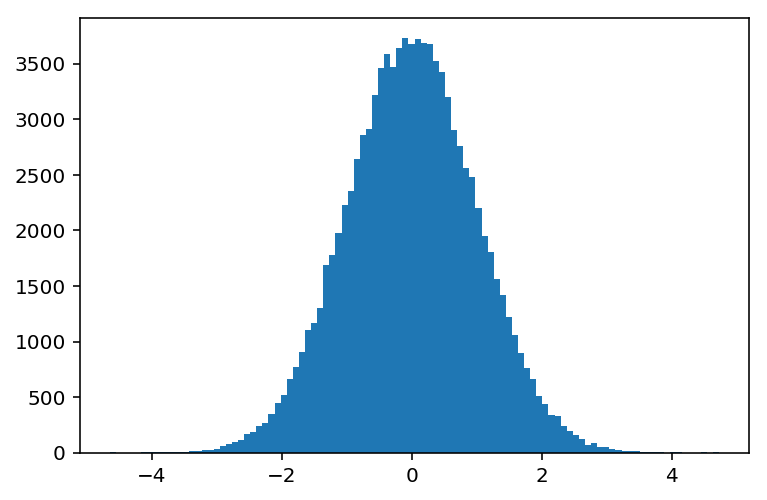

In [33]:
mean = 0
std = 1
samples=100000
plt.hist(np.random.normal(mean, std, samples), bins=100);

The plot above shows a histogram of the result of sampling 100 thousand times from the normal distribution. All this means is that we use the formula for the normal to assign a probability to values - so in the case of the normal, (mean of 0, std of 1) we are very likely to sample input points at or around value 0. 

So what this means is that **input values can be thought of as a distribution of sample points, and we can use a parameterized function to represent or describe this distribution**.

In the same way, output values can be thought of as a distribution.

### Using parameterized functions to map input distributions to output distributions

Another way we can use parameterized functions is to create a mapping from one distribution to another. This is the key idea behind many so called 'supervised' machine learning algorithms - we start with some data distribution and we'd like to generally map these values to some target distribution.

In order to perform this mapping, we can set up a function with parameters, and then define a function that we'd like to minimize given some target distribution and the output distribution. This is the idea behind neural networks.

#### Network error minimization using the gradient

When we want to match an output distribution to a target distirbution via some parameterized function, we need to define a way to measure how far off the output distribution was from the target. This is what the **cost function** of a neural network does for us.

But if we think about what a neural network really, is, we can see that the network in totality is just a nested function that contains parameters. Consider a 1 layered neural network

$$C(target, x) = target - f_1(x)$$
...where $f_1(x)$ is a single layer.

For deeper networks, where there are more than one layer, we can nest the functions. Since the outputs of the first layer are fed as inputs to the second layer, we can write the second layer as 

$$f_2(f_1(x))$$

If we wish to add more layers, we continue to nest the functions. For example...

$$f_4(f_3(f_2(f_1(x))))$$

So when we are training the parameters of a neural network, we are really performing a function minimization problem on a big nested function where the value we are minimizing is produced by the outer most nested function - the cost function. We pass the cost function two values, the output of the network and some target, and then we can use gradient descent to change the parameters until the function is minimized.

When we want to use the network to make predictions, we discard the cost function (the outer most layer) and we just return the outputs of the network.

### Backpropogation and gradient descent

When we talk about finding the gradient, we mean that we want the vector of partial derivatives for each output  and we use the weight matrix to compute this since this is the thing that represents our function.

The transfer of error between each layer is called **backpropagation** and it is made possible by the chain rule, which states that the derivative of two nested functions (or in other words, a function that can be interpreted as nested) is the product of the derivative of the outer function when the inner function is substituted for a single variable and the derivative of the inner function. As it turns out, you can actually apply this rule to functions that are nested 2, 3, 4 or more times... such as a neural network.

#### Summary of Backpropogation

Since our parameters are in nested functions, we need a way to transfer the error computed with the cost function back to the inner parameters. This is where the backprop algorithm comes in.

(1)  $\delta^L = \bigtriangledown_a C \bigodot \sigma '(z^L)$  

- _gradient of output layer (from cost function)_
- _Says: pass the target and prediction through the derivative of the cost function and multiply by the network output passed through the derivative of the derivative of the output layer_

(2)  $\delta^l = \delta^{l+1}(w^{l+1})^T \bigodot \sigma '(z^L)$

- _gradient of layer below the cost function_
- _Says: To backpropogate the error to the layer below, compute dot product of later layer and weights below transposed and multiply by output of layer below passed through derivative of that layers activation function (if any)_

(3)  $\frac{\delta C}{\delta b^{l}_{j}} = \delta^{l}_{j}$ 
 - _Compute the bias update for a given layer_
 - _Says: bias update equals the gradient vector for that layer!_ 
 - _To update the bias, subtract scaled bias update from bias_

(4)  $\frac{\delta C}{\delta w^{l}_{jk}} = a^{l-1}_{k}\delta^{l}_{j}$
 - _Compute the weights update for a given layer_
 - _Says: weight update equals the dot product of the output of the layer below the current delta transposed with the current delta_
 - _To update the weights, subtract the scaled weight update from the weights_

![backprop](./images/backprop.png)
http://neuralnetworksanddeeplearning.com/chap2.html

#### Implementation of backprop

In [34]:
try: #ignore

    # Forward Pass
    hidden_layer_out = logistic(np.dot(input_samples,    hidden_params) + hidden_bias)
    network_out      = logistic(np.dot(hidden_layer_out, output_params) + output_bias)

    # backprop
    output_gradient_vector = loss_function_deriv(pred, batch_target) * logistic_deriv(network_out)
    hidden_gradient_vector = np.dot(output_gradient_vector, output_params.T) * logistic_deriv(hidden_layer_out)

    # gradient descent to update function params
    hidden_params -= np.dot(input_samples.T, hidden_gradient_vector) * scaling_coef
    hidden_bias -= hidden_gradient_vector * scaling_coef

    output_params -= np.dot(hidden_layer_out.T, output_gradient_vector) * scaling_coef
    output_bias -= output_gradient_vector * scaling_coef

except: # ignore
    pass

### What might the gradient look like?

If you think of the neural network as an optimization problem, then it has some plot like we've been seeing that is neither 2d nor 3d, but something higher dimensional. You can think of the output prediction as a point on the surface of this plot, and the labels we've provided as the points that define the surface and its contours. When we use the gradient, we find directions on this surface that point us towards parameter values that minimize the error.

For example the plot below shows the 3d surface of a function that maps two variables $x$ and $y$ to a third dependant variable $z$. 

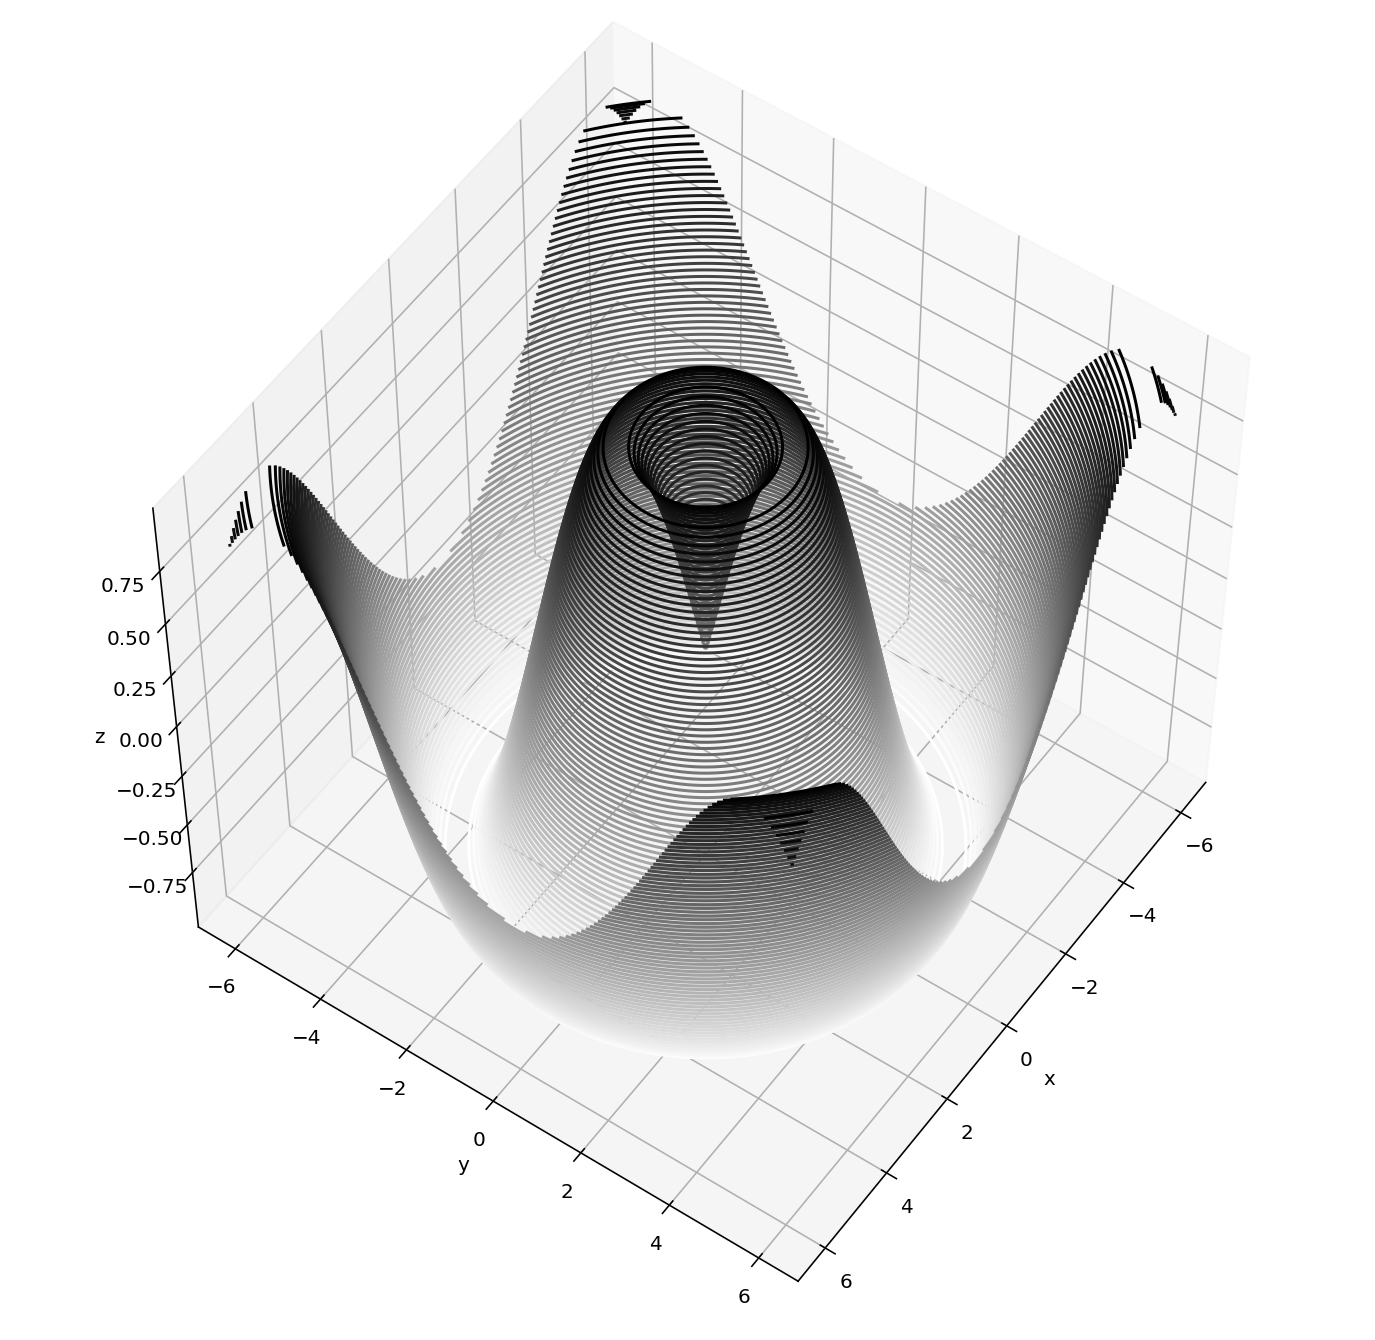

In [35]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 1500)
y = np.linspace(-6, 6, 1500)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 90, cmap='binary')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');
ax.view_init(55, 35)

The dimensions of this plot for a parameterized function such as a neural network are governed by the number of parameters in the function. In other words, each parameter is another axis. This is why the **partial derivative** is so important - we need the direction to travel for each axis. 

Since we don't really know what the surface of the target looks like, it stands to reason that we should try to make as much use as we can of the gradient information that can derive from the parameterized function we mean to optimize.

When we compute the matrix of partial derivaties, we call this matrix a **Jacobian** matrix. Gradient descent makes use of the Jacobian and it tell us the directions in which we should step. It doesn't tell us how much we should step or if an directions are more important than others. For example, imagine that we need to descend the surface of a function that looks like $f(x) = x^2 - y^2$

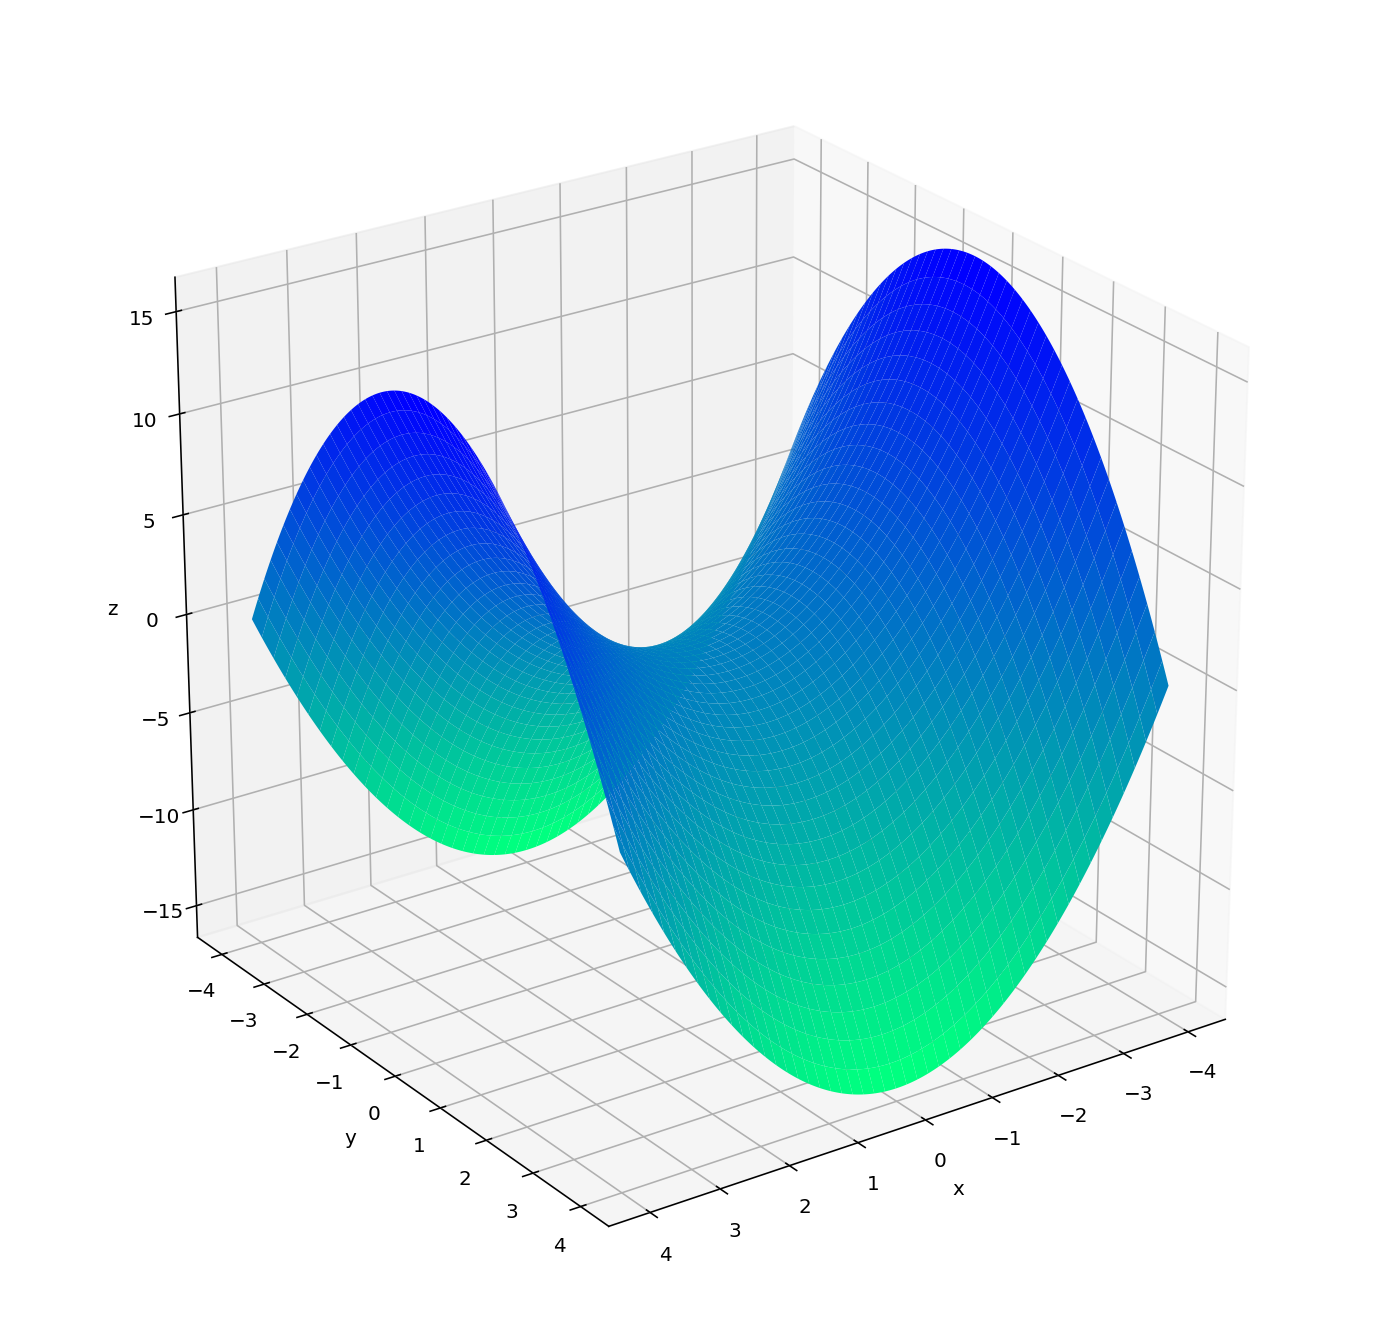

In [36]:
def f(x, y):
    return x**2 - y**2

x = np.linspace(-4, 4, 300)
y = np.linspace(-4, 4, 300)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='winter_r')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');
ax.view_init(25, 55)

# ![coolfunction](https://github.com/paulegradie/ML_bookclub/blob/master/3_function_optimization/images/cool_function.png "x^2-y^2")

Gradient descent will give us the directions we need to descend, however in order to gain information about the importance of each step, we need the second derivatives of our function. This is the derivative of the derivative and the matrix of second derivatives (derived from the Jacobian) is referred to as the **Hessian**.


### Lets stop here
We don't really need to go beyond this point, but it's useful to know that optimization strategies that make use of the Hessian take advantage of directional importance which can be useful for speeding up optimization and avoiding critical points such as saddle points.

Saddle points are those points where the derivative is zero, but there is still further to descend without being at a local minium.

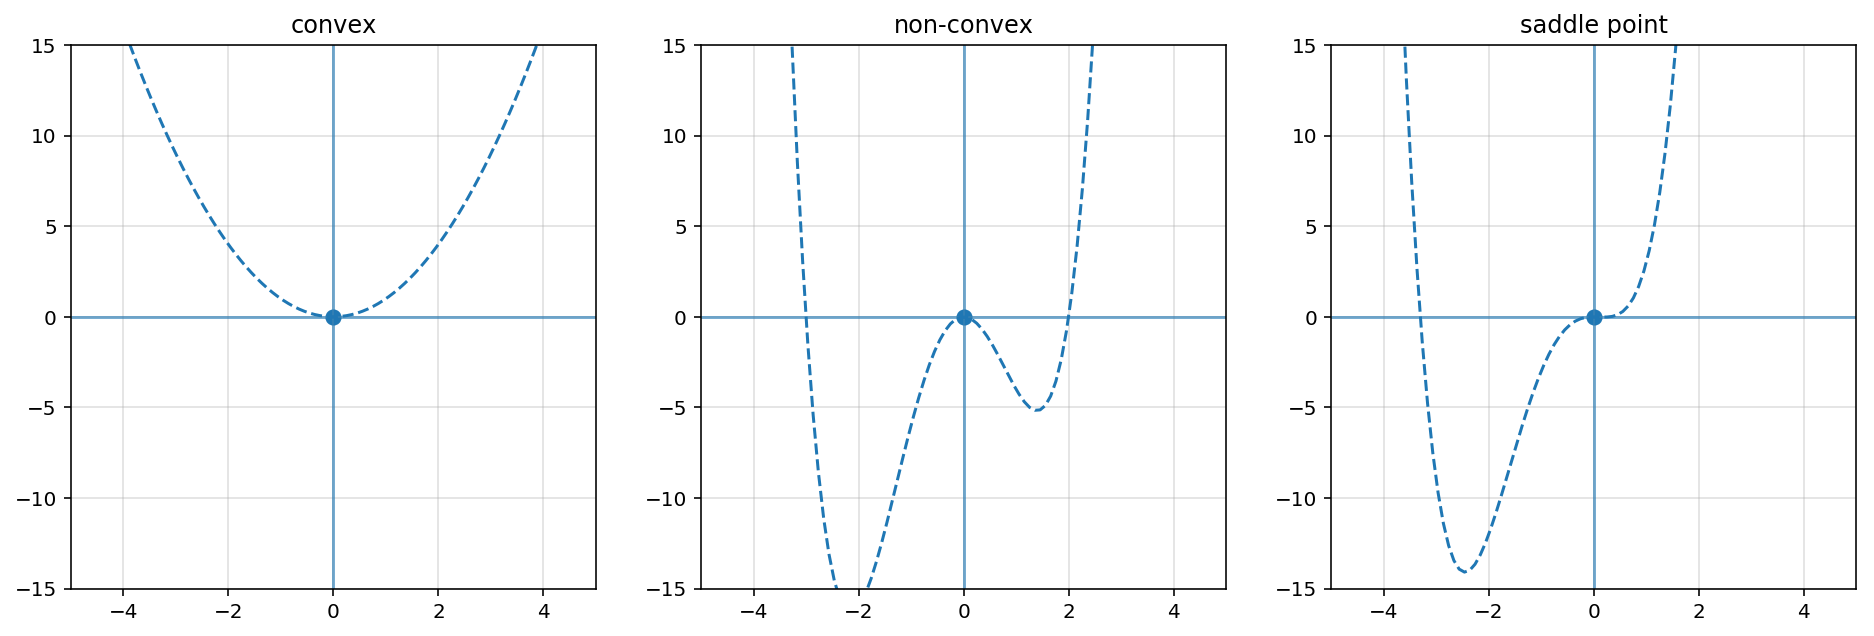

In [37]:
# optimization in 2d
def convex(x):
    return  x**2

def non_convex(x):  
    return (x**4) + (x**3) - (6*x**2)

def curve_saddle(x):  
    return (x**4) + (3*x**3) - (x**2)


x = np.linspace(-10, 10, 200)
funcs = [convex, non_convex, curve_saddle]
titles = ['convex', 'non-convex', 'saddle point']

fig, axes = plt.subplots(nrows=1, ncols=3, **{'figsize':(16, 5)})
for title, func, ax in zip(titles, funcs, axes.flatten()):
    y = func(x)
    ax.plot(x, y, linestyle='--'); ax.scatter(0, 0, s=50)
    formatter(ax=ax, title=title)
    ax.set_ylim((-15, 15)); ax.set_xlim((-5, 5))

To mitigate the problem of local minima, we use various techniques while training such as regularization and certain approaches to initialization of parameter (weight) matrices. Typically, for feed-forward networks, you'll find that peopel typically intialize the weights drawing values from a normal distribution with mean of zero and a standard deviation of 0.01.

# Summary

In this notebook we have explored some of the basic ideas behind function optimization. We've looked at techniques for minimizing and maximizing explicitely defined single and multivariable functions using calculus with some nice visuals. We've also looked at optimizing parameterized functions using these same techniques.

We then applied these concepts to neural networks and reasoned about the composition of a neural network to figure out that we can treat the network as a single parameterized function. We then studied the backpropogation algorithm to learn out precisely how to update the parameters during training.